<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/ai_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC5320 Week6a codes: Time series future prediction (Facebook Prophet)

2022.4.6.<br>

Author: Hyunjoo Yang (hyang@sogang.ac.kr)<br><br>

This notebook uses Facebook's Prophet to predict future stock prices.<br><br>

For Facebook's Prophet, refer to:<br>
https://facebook.github.io/prophet/ <br><br>

Codes are based on: <br>
https://github.com/PinkWink/DataScience/blob/master/source_code/07.%20Time%20Series%20Data%20Handle.ipynb <br>

# 1. Import

In [2]:
!pip install finance-datareader

     |████████████████████████████████| 48 kB 2.6 MB/s 


In [4]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
import FinanceDataReader as fdr

# 2. Data preparation

In [5]:
# SET START AND END DATE FOR STOCK PRICES HERE

df = fdr.DataReader('AAPL', '1997','2016')
test_df = fdr.DataReader('AAPL', '2017','2022')

In [6]:
# check dtypes of variables

df.dtypes

Close     float64
Open      float64
High      float64
Low       float64
Volume    float64
Change    float64
dtype: object

In [22]:
df[0:20]['Close']

Date
1997-01-02    0.19
1997-01-03    0.19
1997-01-06    0.16
1997-01-07    0.16
1997-01-08    0.16
1997-01-09    0.16
1997-01-10    0.16
1997-01-13    0.16
1997-01-14    0.16
1997-01-15    0.15
1997-01-16    0.15
1997-01-17    0.15
1997-01-20    0.15
1997-01-21    0.15
1997-01-22    0.15
1997-01-23    0.15
1997-01-24    0.15
1997-01-27    0.15
1997-01-28    0.15
1997-01-29    0.15
Name: Close, dtype: float64

In [21]:
# convert dtypes to integer
# df_mystock = df_mystock.astype('int32')
df.shape
df[0:0+19].shape
df.iloc[20]

Close     1.500000e-01
Open      1.500000e-01
High      1.500000e-01
Low       1.500000e-01
Volume    1.399300e+08
Change    0.000000e+00
Name: 1997-01-30 00:00:00, dtype: float64

In [60]:
i = 0
x_data_list = []
label_list = []
new_df = pd.DataFrame()
while True:
  x_data = df[i:i+20]['Close']
  new_df.append(df[i:i+20]['Close'])
  try:
    change = df.iloc[i+20]['Change']
  except:
    break
  if change <= 0 :
    label = 0
  if change > 0 :
    label = 1
  x_data_list.append(x_data)
  label_list.append(label)
  i += 1
print(x_data_list[0])
print(label_list[0])
print(new_df.shape)

Date
1997-01-02    0.19
1997-01-03    0.19
1997-01-06    0.16
1997-01-07    0.16
1997-01-08    0.16
1997-01-09    0.16
1997-01-10    0.16
1997-01-13    0.16
1997-01-14    0.16
1997-01-15    0.15
1997-01-16    0.15
1997-01-17    0.15
1997-01-20    0.15
1997-01-21    0.15
1997-01-22    0.15
1997-01-23    0.15
1997-01-24    0.15
1997-01-27    0.15
1997-01-28    0.15
1997-01-29    0.15
Name: Close, dtype: float64
0
(0, 0)


In [43]:
print(x_data_list[0].values)

[0.19 0.19 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15]


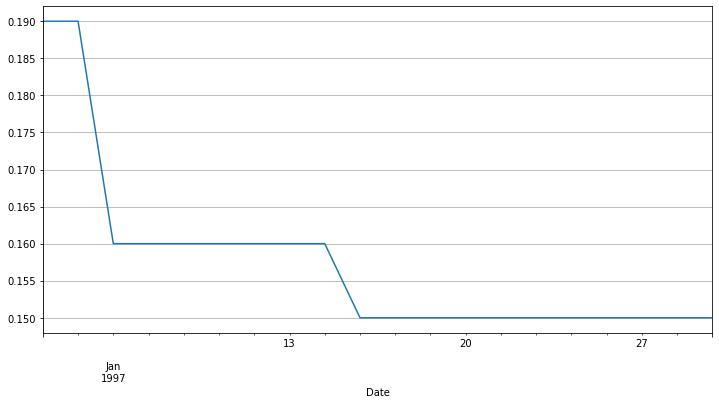

In [36]:
# plot closing stock prices 
x_data_list[0].plot(figsize=(12,6), grid=True);

In [57]:
x_array = np.array([[]])
label_array = np.array([])
i = 0
print(x_array.shape)
for item in x_data_list:
  x_array = np.concatenate((x_array,np.array([item.values])),axis=-1)
  i+=1
  if i ==3:
    break
x_array

(1, 0)


array([[0.19, 0.19, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.15,
        0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.19, 0.16,
        0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15,
        0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16,
        0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
        0.15, 0.15, 0.15, 0.15, 0.15]])

# 3. Train (fit)

In [ ]:
# Prepare train data set
# SET TRAIN SET DURATION HERE

df_mystock_trunc = df_mystock[:'2016-12-31']
df_mystock_trunc

In [ ]:
# create a final train dataset for training

df = pd.DataFrame({'ds':df_mystock_trunc.index, 'y':df_mystock_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df

In [ ]:
# train using Prophet

myprophet = Prophet()
myprophet.fit(df)

# 4. Predict future

In [ ]:
# create future periods

future = myprophet.make_future_dataframe(periods=365)
future

In [ ]:
# predict

forecast = myprophet.predict(future)
forecast

In [ ]:
# plot forecast

myprophet.plot(forecast);

In [ ]:
# plot components of forecast

myprophet.plot_components(forecast);

In [ ]:
# compare actual and forecast

plt.figure(figsize=(12,6))
plt.plot(df_mystock.index, df_mystock['Close'], label='actual')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()